#DATASCI W261: Machine Learning at Scale

**Nick Hamlin** (nickhamlin@gmail.com)  
**Tigi Thomas** (tgthomas@berkeley.edu)  
**Rock Baek** (rockb1017@gmail.com)  
**Hussein Danish** (husseindanish@gmail.com)  
  
Time of Submission: 9:23 PM EST, Wednesday, Feb 17, 2016  
W261-3, Spring 2016  
Week 5 Homework

###Submission Notes:
- For each problem, we've included a summary of the question as posed in the instructions.  In many cases, we have not included the full text to keep the final submission as uncluttered as possible.  For reference, we've included a link to the original instructions in the "Useful Reference" below.
- Problem statements are listed in *italics*, while our responses are shown in plain text. 
- We've included the full output of the mapreduce jobs in our responses so that counter results are shown.  However, these don't always render nicely into PDF form.  In these situations, please reference [the complete rendered notebook on Github](https://github.com/nickhamlin/mids_261_homework/blob/master/HW4/MIDS-W261-2015-HWK-Week04-Hamlin-Thomas-Baek-Danish.ipynb)

###Useful References:
- **[Original Assignment Instructions](https://www.dropbox.com/sh/0cv65h44zylqwe3/AADyEEBMPGezLplMmNwAFIkba/hw5-Questions.txt?dl=0)**

In [1]:
#Use this to make sure we reload the MrJob code when we make changes
%load_ext autoreload
%autoreload 2

##HW5.0.  
*What is a data warehouse? What is a Star schema? When is it used?*

##HW 5.1
*In the database world What is 3NF? Does machine learning use data in 3NF? If so why?*

*In what form does ML consume data?*

*Why would one use log files that are denormalized?*


## HW 5.2

###Problem Statement
Using MRJob, implement a hashside join (memory-backed map-side) for left, 
right and inner joins. Run your code on the  data used in HW 4.4: (Recall HW 4.4: Find the most frequent visitor of each page using mrjob and the output of 4.2  (i.e., transfromed log file). In this output please include the webpage URL, webpageID and Visitor ID.)
:

Justify which table you chose as the Left table in this hashside join.

Please report the number of rows resulting from:

(1) Left joining Table Left with Table Right  
(2) Right joining Table Left with Table Right  
(3) Inner joining Table Left with Table Right  

### Generating source data
We'll start by running a slightly modified version of the code from HW4 to generate our two sets of source data

In [3]:
%%writefile convert_msdata.py
#HW 4.2 - Attach customer IDs to page view records

from csv import reader
with open('anonymous-msweb.data','rb') as f:
    data=f.readlines()
    
for i in reader(data):
    if i[0]=='C':
        visitor_id=i[1] #Store visitor id
        continue
    if i[0]=='V':
        print i[0]+','+i[1]+','+i[2]+',C,'+visitor_id #Append visitor_id to each pageview

Writing convert_msdata.py


In [4]:
%%writefile create_urls.py
#HW 4.2 - Extract URLs (not explicitly required, but for later use in 4.4)

#Save only results from 'A' rows into their own file for easy URL access in the future
from csv import reader
with open('anonymous-msweb.data','rb') as f:
    data=f.readlines()
    
for i in reader(data):
    if i[0]=='A':
        print i[1]+','+i[3]+','+i[4]

Writing create_urls.py


In [6]:
%%writefile freq_visitor.py
# HW 4.4 - MRJob Code

import csv
from collections import Counter
from operator import itemgetter

from mrjob.job import MRJob
from mrjob.step import MRStep


def csv_readline(line):
    """Given a string CSV line, return a list of strings."""
    for row in csv.reader([line]):
        return row

class FreqVisitor(MRJob):

    def mapper_extract_views(self, line_no, line):
        """Extracts the page that was visited and the visitor id"""
        cell = csv_readline(line)
        #Ignore any irrelevant messy data, though hopefully we don't have any since we preprocessed the file
        if cell[0] == 'V': 
            yield cell[1],cell[4]
    
    def reducer_load_urls(self):
        """Load file of page URLs into reducer memory"""
        with open('ms_urls.txt','rb') as f:
            urls=csv.reader(f.readlines())
        self.url_dict={}
        for i in urls:
            #Saving the URLs into a dictionary will make it easy to access them later
            self.url_dict[int(i[0])]=i[2]

    def reducer_sum_views_by_visitor(self, vroots, visitor):
        """Summarizes visitor counts for each page, 
        yields one record per page with the visitor responsible for  
        the most views on that page"""
        visitors=Counter()
        for i in visitor:
            visitors[i]+=1 #Aggregate page views for all visitors
        output= max(visitors.iteritems(), key=itemgetter(1))[0] #Find visitor responsible for the most page views
        yield (str(vroots)),(output,visitors[output],self.url_dict[int(vroots)])
   
    def steps(self):
        return [MRStep(mapper=self.mapper_extract_views,
                        reducer_init=self.reducer_load_urls,
                        reducer=self.reducer_sum_views_by_visitor)]
        
if __name__ == '__main__':
    FreqVisitor.run()

Writing freq_visitor.py


In [ ]:
#Make files executable, convert data, and view some example results to check that everything worked
#!chmod +x convert_msdata.py create_urls.py
!python convert_msdata.py > clean_msdata.txt
!cat clean_msdata.txt | head -10
!python create_urls.py > ms_urls.txt

In [8]:
%%writefile freq_visitor_driver.py
#HW 4.4 - Driver Function
from freq_visitor import FreqVisitor
import csv

mr_job = FreqVisitor(args=['clean_msdata.txt','--file','ms_urls.txt'])
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        output=mr_job.parse_output_line(line)
        print str(output[0])+'\t'+str(output[1][0])+'\t'+str(output[1][1])+'\t'+str(output[1][2])

Writing freq_visitor_driver.py


In [ ]:
#Make files executable, convert data, and view some example results to check that everything worked
!chmod +x freq_visitor_driver.py
!python freq_visitor_driver.py > freq_visitor_data.txt

### HW 5.2 - Setting up the joins
Using MRJob, implement a hashside join (memory-backed map-side) for left, 

*Justify which table you chose as the Left table in this hashside join.*

Since we're doing a memory-backed map-side join, we want to load the smaller of the two datasets into memory.  Therefore, we'll choose the list of most frequent visitors per page that we generated in 4.4 as our left table and the list of URLs as our right table that we'll load during the mapper_init step.

Please report the number of rows resulting from:

###(1) Left joining Table Left with Table Right   

In [106]:
%%writefile left_join.py
# HW 5.2A - Left join MRJob Code
import csv

from mrjob.job import MRJob
from mrjob.step import MRStep

class LeftJoin(MRJob):
    
    def mapper_init(self):
        """Load file of page URLs into reducer memory"""
        with open('ms_urls.txt','rb') as f:
            urls=csv.reader(f.readlines())
        self.url_dict={}
        for i in urls:
            #Saving the URLs into a dictionary will make it easy to access them later
            self.url_dict[int(i[0])]=i[2]
        

    def mapper(self, _, line):
        """Extracts the page that was visited and the visitor id"""
        line=line.strip().split('\t')
        page=line[0]
        visitor=line[1]
        #This is the "Left Join" logic that ensures that a row will be returned for
        #every row in the 
        try:
            url=self.url_dict[int(page)]
        except KeyError:
            url='NONE'
        yield page,(visitor,url)
   
    def steps(self):
        return [MRStep(
                mapper_init=self.mapper_init,
                mapper=self.mapper,
                )]
        
if __name__ == '__main__':
    LeftJoin.run()

Overwriting left_join.py


In [111]:
#HW 5.2 - Left Join Driver Function
from left_join import LeftJoin
import csv

mr_job = LeftJoin(args=['freq_visitor_data.txt','--file','ms_urls.txt'])
number_of_rows=0
with mr_job.make_runner() as runner:
    runner.run()
    #print 'Page | Visitor ID | URL'
    for line in runner.stream_output():
        output=mr_job.parse_output_line(line)
        number_of_rows+=1
        #print output[0], output[1][0], output[1][1]
        
print "Left Join returned {0} results".format(str(number_of_rows))



Page | Visitor ID | URL
Left Join returned 285 results


###(2) Right joining Table Left with Table Right  

In [128]:
%%writefile right_join.py
# HW 5.2A - Left join MRJob Code
import csv

from mrjob.job import MRJob
from mrjob.step import MRStep

class RightJoin(MRJob):
    
    def mapper_init(self):
        """Load file of page URLs into memory"""
        with open('ms_urls.txt','rb') as f:
            urls=csv.reader(f.readlines())
        self.url_dict={}
        for i in urls:
            #Saving the URLs into a dictionary will make it easy to access them later
            #the second term here is a flag to see if we've emitted a record yet
            self.url_dict[int(i[0])]=[i[2],0] 
        

    def mapper(self, _, line):
        """Extracts the page that was visited and the visitor id"""
        line=line.strip().split('\t')
        page=line[0]
        visitor=line[1]
        #This is the "Inner Join" logic that emits a row for every record appearing in both 
        #tables
        try:
            url=self.url_dict[int(page)][0]
            self.url_dict[int(page)][1]=1 #set flag to indicate we've emitted the record
            yield page,(visitor,url)
        except KeyError:
            pass
        
    
    def mapper_final(self):
        """emit any records in the right table we haven't seen yet"""
        for i in self.url_dict.iteritems():
            if i[1][1]==0:
                page=i[0]
                url=i[1][0]
                yield page,('NONE',url)
   
    def steps(self):
        return [MRStep(
                mapper_init=self.mapper_init,
                mapper=self.mapper,
                mapper_final=self.mapper_final
                )]
        
if __name__ == '__main__':
    RightJoin.run()

Overwriting right_join.py


In [129]:
#HW 5.2 - Right Join Driver Function
from right_join import RightJoin
import csv

mr_job = RightJoin(args=['freq_visitor_data.txt','--file','ms_urls.txt'])
number_of_rows=0
with mr_job.make_runner() as runner:
    runner.run()
    #print 'Page | Visitor ID | URL'
    for line in runner.stream_output():
        output=mr_job.parse_output_line(line)
        number_of_rows+=1
        #print output[0], output[1][0], output[1][1]
        
print "Right Join returned {0} results".format(str(number_of_rows))



Right Join returned 294 results


###(3) Inner joining Table Left with Table Right 

In [113]:
%%writefile inner_join.py
# HW 5.2A - Inner join MRJob Code
import csv

from mrjob.job import MRJob
from mrjob.step import MRStep

class InnerJoin(MRJob):
    
    def mapper_init(self):
        """Load file of page URLs into memory"""
        with open('ms_urls.txt','rb') as f:
            urls=csv.reader(f.readlines())
        self.url_dict={}
        for i in urls:
            #Saving the URLs into a dictionary will make it easy to access them later
            #the second term here is a flag to see if we've emitted a record yet
            self.url_dict[int(i[0])]=[i[2],0] 
        

    def mapper(self, _, line):
        """Extracts the page that was visited and the visitor id"""
        line=line.strip().split('\t')
        page=line[0]
        visitor=line[1]
        #This is the "Inner Join" logic that emits a row for every record appearing in both 
        #tables
        try:
            url=self.url_dict[int(page)][0]
            self.url_dict[int(page)][1]=1 #set flag to indicate we've emitted the record
            yield page,(visitor,url)
        except KeyError:
            #Skip records that don't appear in both tables
            pass
        
   
    def steps(self):
        return [MRStep(
                mapper_init=self.mapper_init,
                mapper=self.mapper
            )]
        
if __name__ == '__main__':
    InnerJoin.run()

Overwriting inner_join.py


In [114]:
#HW 5.2 - Inner Join Driver Function
from inner_join import InnerJoin
import csv

mr_job = InnerJoin(args=['freq_visitor_data.txt','--file','ms_urls.txt'])
number_of_rows=0
with mr_job.make_runner() as runner:
    runner.run()
    #print 'Page | Visitor ID | URL'
    for line in runner.stream_output():
        output=mr_job.parse_output_line(line)
        number_of_rows+=1
        #print output[0], output[1][0], output[1][1]
        
print "Inner Join returned {0} results".format(str(number_of_rows))



Inner Join returned 285 results


## HW 5.3
For the remainder of this assignment you will work with two datasets:

-1: unit/systems test data set: SYSTEMS TEST DATASET
Three terms, A,B,C and their corresponding strip-docs of co-occurring terms

DocA {X:20, Y:30, Z:5}
DocB {X:100, Y:20}
DocC {M:5, N:20, Z:5}


-2: A large subset of the Google n-grams dataset

https://aws.amazon.com/datasets/google-books-ngrams/

which we have placed in a bucket/folder on Dropbox on s3:

   https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACUifrl6wrMrlK6a3X3lZ9Ea?dl=0 

   s3://filtered-5grams/

For each HW 5.3 -5.5 Please unit test and system test your code with with SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations. Then show the results you get with you system.
Final show your results on the Google n-grams dataset


In particular, this bucket contains (~200) files (10Meg each) in the format:

	(ngram) \t (count) \t (pages_count) \t (books_count)

Do some EDA on this dataset using mrjob, e.g., 

- Longest 5-gram (number of characters)
- Top 10 most frequent words (count), i.e., unigrams
- Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency (Hint: save to PART-000* and take the head -n 1000)
- Distribution of 5-gram sizes (counts) sorted in decreasing order of relative frequency. (Hint: save to PART-000* and take the head -n 1000)
- OPTIONAL Question: Plot the log-log plot of the frequency distributuion of unigrams. Does it follow power law distribution?

For more background see:
- https://en.wikipedia.org/wiki/Log%E2%80%93log_plot  
- https://en.wikipedia.org/wiki/Power_law  


### Longest N-Gram (by number of characters)

In [2]:
%%writefile longest_ngram.py
#HW 5.3 - MRJob Definition
import csv

from mrjob.job import MRJob
from mrjob.step import MRStep

class LongestNgram(MRJob):

    def mapper(self, _, line):
        """ """
        line=line.strip().split('\t')
        ngram=line[0]
        yield None,(len(ngram),ngram)
        
    def reducer(self, _, ngram_and_length):
        """ """
        yield None, max(ngram_and_length)
        
    def steps(self):
        return [
            MRStep(mapper=self.mapper
                   ,combiner=self.reducer
                    ,reducer=self.reducer
                  )        
        ]
        
if __name__ == '__main__':
    LongestNgram.run()

Overwriting longest_ngram.py


In [3]:
#HW 4.3 - Driver Function
from longest_ngram import LongestNgram
#import csv

mr_job = LongestNgram(args=['testngrams.txt'])
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)


(None, [34, 'A HANDBOOK ON THEODOLITE SURVEYING'])


In [ ]:
! python ./longest_ngram.py \
    -r emr s3://filtered-5grams  \
    --conf-path ./mrjob.conf \
    --output-dir=s3://hamlin-mids-261/longest_ngram \
    --no-output \
    --no-strict-protocol

### Top 10 Most Frequent Words

In [199]:
%%writefile most_freq_words.py
#HW 5.3 - MRJob Definition
import csv
import re

from mrjob import conf
from mrjob.job import MRJob
from mrjob.step import MRStep

class MostFreqWords(MRJob):
    
    SORT_VALUES = True
    
    def configure_options(self):
        super(MostFreqWords, self).configure_options()
        
    def jobconf(self):
        orig_jobconf = super(MostFreqWords, self).jobconf()
        
        custom_jobconf = {
            'mapreduce.partition.keypartitioner.options': '-k1,1',
            'mapreduce.job.output.key.comparator.class' :
              'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k2nr'
        }
        return conf.combine_dicts(orig_jobconf, custom_jobconf)
    
    #SORT_VALUES=True
    
#     def jobconf(self):
#         orig_jobconf = super(MostFreqWords, self).jobconf()        
#         custom_jobconf = {  #key value pairs
#             'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
#             'mapred.text.key.comparator.options': '-k2,2nr',
#             #'mapred.partition.keypartitioner.options':'-k1,1',
#             'mapred.reduce.tasks': '1',
#         }
#         combined_jobconf = orig_jobconf
#         combined_jobconf.update(custom_jobconf)
#         self.jobconf = combined_jobconf
#         return combined_jobconf
            
    def mapper(self, _, line):
        counts = {}
        line.strip()
        [ngram,count,pages,books] = re.split("\t",line)
        count = int(count)
        words = re.split(" ",ngram)
        for word in words:
            counts.setdefault(word.lower(),0)
            counts[word.lower()] += count
        for word in counts.keys():
            yield word,counts[word]
    
    def combiner(self,word,count):
        yield word,sum(count)
            
    def reducer(self,word,count):
        yield word,sum(count)
        
#     def mapper_id(self,word,count):
#         yield word,count  
        
#     def reducer_init(self):
#         pass
        
    def steps(self):
        return [
            MRStep(mapper=self.mapper
                   ,combiner=self.combiner
                    ,reducer=self.reducer
                  )
#             ,MRStep(#mapper=self.mapper_id
#                     reducer_init=self.reducer_init
#                     #reducer=self.mapper_id
#                   )   
        ]
        
if __name__ == '__main__':
    MostFreqWords.run()

Overwriting most_freq_words.py


In [200]:
#HW 4.3 - Driver Function
from most_freq_words import MostFreqWords

mr_job = MostFreqWords(args=['testngrams.txt'])# ,'-r','hadoop','--hadoop-home',"/Users/nicholashamlin/hadoop-2.6.3"])
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)

The have been translated as follows
 mapreduce.job.output.key.comparator.class: mapred.output.key.comparator.class
mapreduce.partition.keypartitioner.options: mapred.text.key.partitioner.options
mapreduce.partition.keycomparator.options: mapred.text.key.comparator.options
The have been translated as follows
 mapreduce.job.output.key.comparator.class: mapred.output.key.comparator.class
mapreduce.partition.keypartitioner.options: mapred.text.key.partitioner.options
mapreduce.partition.keycomparator.options: mapred.text.key.comparator.options
The have been translated as follows
 mapreduce.job.output.key.comparator.class: mapred.output.key.comparator.class
mapreduce.partition.keypartitioner.options: mapred.text.key.partitioner.options
mapreduce.partition.keycomparator.options: mapred.text.key.comparator.options
The have been translated as follows
 mapreduce.job.output.key.comparator.class: mapred.output.key.comparator.class
mapreduce.partition.keypartitioner.options: mapred.text.key.partit

('a', 32811)
('aerial', 61)
('all', 376)
("america's", 98)
('american', 172)
('and', 579)
('apology', 110)
('arithmetic', 79)
('at', 51)
('bibliographical', 56)
('bibliography', 145)
('bill', 59)
('biography', 92)
('by', 156)
('case', 604)
("cat's", 86)
('censorship', 98)
("child's", 1099)
('christmas', 1099)
('circumstantial', 62)
('city', 62)
('collection', 239)
('commentary', 110)
('comparative', 68)
('comparison', 72)
('conceptual', 140)
('concise', 145)
('continuation', 52)
('cradle', 86)
('critical', 197)
('critique', 42)
('defence', 398)
('dirty', 180)
('discovery', 253)
('establishing', 59)
('eurobond', 59)
('fairy', 123)
('female', 447)
('festschrift', 549)
('for', 627)
('forms', 116)
('framework', 140)
('funny', 180)
('further', 51)
('game', 86)
('general', 92)
('george', 92)
('government', 102)
('guide', 140)
('handbook', 61)
('her', 51)
('his', 110)
('historical', 558)
('history', 25718)
('honour', 549)
('in', 2348)
('instruction', 284)
('joint', 94)
('journey', 59)
('juven

In [ ]:
 python ./most_freq_words.py \
    -r emr s3://hamlin-mids-261/testngrams.txt  \
    --conf-path ./mrjob.conf \
    --output-dir=s3://hamlin-mids-261/test \
    --no-output \
    --no-strict-protocol    

In [28]:
 python ./most_freq_words.py \
    -r emr s3://filtered-5grams  \
    --conf-path ./mrjob.conf \
    --output-dir=s3://hamlin-mids-261/most_freq_words \
    --no-output \
    --no-strict-protocol

creating new scratch bucket mrjob-46dd62fe4baf7a13
using s3://mrjob-46dd62fe4baf7a13/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/most_freq_words.nicholashamlin.20160214.182523.935641
writing master bootstrap script to /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/most_freq_words.nicholashamlin.20160214.182523.935641/b.py
creating S3 bucket 'mrjob-46dd62fe4baf7a13' to use as scratch space
Copying non-input files into s3://mrjob-46dd62fe4baf7a13/tmp/most_freq_words.nicholashamlin.20160214.182523.935641/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-293AF6MIHM0DD
Created new job flow j-293AF6MIHM0DD
Job launched 30.4s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 60.7s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 91.5s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 121.8s ago, status STARTING: Provis

In [134]:
#! mkdir ./freq_word_output
#! aws s3 cp --recursive s3://hamlin-mids-261/most_freq_words ./freq_word_output 
#!cat ./freq_word_output/part-* | sort -k2nr | head -10000 > ./most_freq_words.txt
!cat ./most_freq_words.txt | head -10

"the"	5490815394
"of"	3698583299
"to"	2227866570
"in"	1421312776
"a"	1361123022
"and"	1149577477
"that"	802921147
"is"	758328796
"be"	688707130
"as"	492170314
cat: stdout: Broken pipe


In [137]:
#Make another version of this file for use in 5.4 that excludes "stopwords"
!cat ./most_freq_words.txt | tail -9000 >most_freq_words_ex_stopwords.txt
!cat ./most_freq_words_ex_stopwords.txt | head -10

"resources"	4518986
"conduct"	4515495
"coast"	4513944
"management"	4509226
"thinking"	4502684
"creation"	4494276
"visit"	4487509
"college"	4486762
"journal"	4474243
"occasion"	4465835
cat: stdout: Broken pipe


### Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency (Hint: save to PART-000* and take the head -n 1000)

In [193]:
%%writefile word_density.py
#HW 5.3 - MRJob Definition
from __future__ import division
import csv

from mrjob.job import MRJob
from mrjob.step import MRStep

class WordDensity(MRJob):

    def mapper(self, _, line):
        """ """
        line=line.strip().split('\t')
        ngram=line[0]
        count=line[1]
        page_count=line[2]
        for word in ngram.split(' '):
            yield word,(count,page_count)
            
    def combiner(self,word,count):
        word_count=0
        page_count=0
        for record in count:
            word_count+=int(record[0])
            page_count+=int(record[1])
        yield word,(word_count,page_count)
                    
    def reducer(self,word,count):
        word_count=0
        page_count=0
        for record in count:
            word_count+=int(record[0])
            page_count+=int(record[1])
        yield word,word_count/page_count
        
    def steps(self):
        return [
            MRStep(mapper=self.mapper
                   ,combiner=self.combiner
                    ,reducer=self.reducer
                  )        
        ]
        
if __name__ == '__main__':
    WordDensity.run()

Overwriting word_density.py


In [194]:
!chmod +x word_density.py

In [192]:
#HW 4.3 - Driver Function
from word_density import WordDensity

mr_job = WordDensity(args=['testngrams.txt'])
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)


('A', 1.0588044078925982)
('ALL', 1.0301369863013699)
('AT', 1.02)
('Aerial', 1.0)
("America's", 1.0)
('American', 1.0058479532163742)
('Apology', 1.0)
('Arithmetic', 1.0)
('BILL', 1.0)
('Bibliographical', 1.0)
('Bibliography', 1.013986013986014)
('Biography', 1.0222222222222221)
('Case', 1.0)
("Cat's", 1.0)
('Censorship', 1.0)
("Child's", 1.0358152686145146)
('Christmas', 1.0358152686145146)
('Circumstantial', 1.0)
('City', 1.0333333333333334)
('Collection', 1.0863636363636364)
('Commentary', 1.0)
('Comparative', 1.0625)
('Comparison', 1.0)
('Conceptual', 1.0)
('Concise', 1.013986013986014)
('Continuation', 1.0196078431372548)
('Cradle', 1.0)
('Critical', 1.0154639175257731)
('Critique', 1.0)
('Defence', 1.028423772609819)
('Dirty', 1.1688311688311688)
('Discovery', 1.0079681274900398)
('ESTABLISHING', 1.0)
('Eurobond', 1.0172413793103448)
('FOR', 1.0441767068273093)
('FURTHER', 1.02)
('Fairy', 1.0512820512820513)
('Female', 1.0)
('Festschrift', 1.0166666666666666)
('Forms', 1.1262135

In [28]:
 python ./word_density.py \
    -r emr s3://filtered-5grams  \
    --conf-path ./mrjob.conf \
    --output-dir=s3://hamlin-mids-261/word_density \
    --no-output \
    --no-strict-protocol

creating new scratch bucket mrjob-46dd62fe4baf7a13
using s3://mrjob-46dd62fe4baf7a13/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/most_freq_words.nicholashamlin.20160214.182523.935641
writing master bootstrap script to /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/most_freq_words.nicholashamlin.20160214.182523.935641/b.py
creating S3 bucket 'mrjob-46dd62fe4baf7a13' to use as scratch space
Copying non-input files into s3://mrjob-46dd62fe4baf7a13/tmp/most_freq_words.nicholashamlin.20160214.182523.935641/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-293AF6MIHM0DD
Created new job flow j-293AF6MIHM0DD
Job launched 30.4s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 60.7s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 91.5s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 121.8s ago, status STARTING: Provis

### - Distribution of 5-gram sizes (character length) sorted in decreasing order of relative frequency.  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically.


In [130]:
%%writefile ngram_distribution.py
#HW 5.3 - MRJob Definition
from __future__ import division
import csv

from mrjob.job import MRJob
from mrjob.step import MRStep

class NgramDistribution(MRJob):
    
    def mapper_init(self):
        self.count=0

    def mapper(self, _, line):
        """ """
        line=line.strip().split('\t')
        ngram=line[0] #The text of the ngram
        size=len(ngram)
        ngram_count=int(line[1]) #The count of the ngram
        self.count+=ngram_count #Add the count to the running total of counts
        yield size,ngram_count #Yield the ngram and its count
    
    def mapper_final(self):
        yield '*count',self.count #Yield the total for order-inversion
        
    def reducer_init(self):
        self.total_count=None
            
    def reducer(self,ngram,ngram_count):
        total=sum(ngram_count) #
        overall_total=None
        if ngram=='*count':
            overall_total=total
            self.total_count=total
        else:
            yield ngram,(total)#, total/self.total_count)
        
    def steps(self):
        return [
            MRStep(
                mapper_init=self.mapper_init,
                mapper=self.mapper
                ,mapper_final=self.mapper_final
                #,combiner=self.reducer
                ,reducer_init=self.reducer_init
                ,reducer=self.reducer
                  )        
        ]
        
if __name__ == '__main__':
    NgramDistribution.run()

Overwriting ngram_distribution.py


In [131]:
#HW 4.3 - Driver Function
from ngram_distribution import NgramDistribution

mr_job = NgramDistribution(args=['testngrams.txt'])
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)


(17, 62)
(19, 191)
(20, 58)
(21, 634)
(22, 1255)
(23, 25376)
(24, 347)
(25, 184)
(26, 994)
(27, 233)
(28, 1373)
(29, 630)
(30, 280)
(31, 215)
(33, 679)
(34, 61)


In [ ]:
 python ./ngram_distribution.py \
    -r emr s3://filtered-5grams  \
    --conf-path ./mrjob.conf \
    --output-dir=s3://hamlin-mids-261/ngram_distribution \
    --no-output \
    --no-strict-protocol    

In [ ]:
 python ./ngram_distribution.py \
    -r emr s3://hamlin-mids-261/testngrams.txt  \
    --conf-path ./mrjob.conf \
    --output-dir=s3://hamlin-mids-261/test \
    --no-output \
    --no-strict-protocol    

In [135]:
#! mkdir ./ngram_distribution_output
#! aws s3 cp --recursive s3://hamlin-mids-261/ngram_distribution ./ngram_distribution_output 

download: s3://hamlin-mids-261/ngram_distribution/_SUCCESS to ngram_distribution_output/_SUCCESS
download: s3://hamlin-mids-261/ngram_distribution/part-00003 to ngram_distribution_output/part-00003
download: s3://hamlin-mids-261/ngram_distribution/part-00005 to ngram_distribution_output/part-00005
download: s3://hamlin-mids-261/ngram_distribution/part-00006 to ngram_distribution_output/part-00006
download: s3://hamlin-mids-261/ngram_distribution/part-00000 to ngram_distribution_output/part-00000
download: s3://hamlin-mids-261/ngram_distribution/part-00001 to ngram_distribution_output/part-00001
download: s3://hamlin-mids-261/ngram_distribution/part-00004 to ngram_distribution_output/part-00004
download: s3://hamlin-mids-261/ngram_distribution/part-00002 to ngram_distribution_output/part-00002


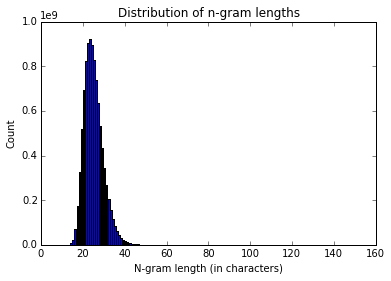

In [182]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt


lengths=[]
totals=[]
#os.chdir('./ngram_distribution_output')
for i in os.listdir(os.getcwd()):
    if i.startswith('part'):
        with open(i) as f:
            for line in f.readlines():
                [length,total]=line.strip().split('\t')
                lengths.append(int(length))
                totals.append(int(total))
                
fig, chart = plt.subplots()
chart.bar(lengths,totals)
chart.set_ylabel('Count')
chart.set_xlabel('N-gram length (in characters)')
chart.set_title('Distribution of n-gram lengths')

fig = plt.gcf()

## HW 5.4

###Problem Statement
In this part of the assignment we will focus on developing methods
for detecting synonyms, using the Google 5-grams dataset. To accomplish
this you must script two main tasks using MRJob:

(1) Build stripes for the most frequent 10,000 words using cooccurence informationa based on
the words ranked from 1001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).

(2) Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.

==Design notes for (1)==  
For this task you will be able to modify the pattern we used in HW 3.2
(feel free to use the solution as reference). To total the word counts 
across the 5-grams, output the support from the mappers using the total 
order inversion pattern:

<*word,count>

to ensure that the support arrives before the cooccurrences.

In addition to ensuring the determination of the total word counts,
the mapper must also output co-occurrence counts for the pairs of
words inside of each 5-gram. Treat these words as a basket,
as we have in HW 3, but count all stripes or pairs in both orders,
i.e., count both orderings: (word1,word2), and (word2,word1), to preserve
symmetry in our output for (2).

==Design notes for (2)==  
For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation
...

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix. 

In [91]:
word_dict={}
with open('testwords.txt','rb') as f:
    for row in f.readlines():
        line=row.strip().split('\t')
        word_dict[line[0]]=line[1] 

In [141]:
%%writefile stripes.py
#HW 5.3 - MRJob Definition
from __future__ import division
from itertools import combinations
import csv

from mrjob.job import MRJob
from mrjob.step import MRStep

class Stripes(MRJob):
    
    def mapper_init(self):
        """Load file of words into memory"""
        self.word_dict={}
        with open('most_freq_words_ex_stopwords.txt','rb') as f:
            for row in f.readlines():
                line=row.strip().split('\t')
                self.word_dict[line[0][1:-1]]=line[1]
        #print self.word_dict

    def mapper(self, _, line):
        """ """
        line=line.strip().split('\t')
        ngram=line[0].lower()
        count=int(line[1])
        potential_words=ngram.split(" ")
        output={}
        #Pull out words from ngram that we care about
        words=[i for i in potential_words if i in self.word_dict.keys()]
        for word1,word2 in combinations(words,2):
            if word1 in output.keys():      
                output[word1][word2]=output[word1].get(word2,0)+count #This should maybe be word_dict instead
            else:
                output[word1]={word2:count}
            
            #This second step ensures we maintain symmetry
            if word2 in output.keys():      
                output[word2][word1]=output[word2].get(word1,0)+count #This should maybe be word_dict instead
            else:
                output[word2]={word1:count}
        
        #"cooccurrences" is what I really want to call the second var, but that's too long to type right
        for word,cos in output.iteritems():
            yield word,cos
            
    def reducer(self,word,cos):
        output_dict={}
        for co in cos:
            for second_word,count in co.iteritems():
                output_dict[second_word] = output_dict.get(second_word,0)+count
        yield word, output_dict
        
        
    def steps(self):
        return [
            MRStep(
                mapper_init=self.mapper_init,
                mapper=self.mapper
                #,mapper_final=self.mapper_final
                ,combiner=self.reducer
                #,reducer_init=self.reducer_init
                ,reducer=self.reducer
                #,reducer_final=self.reducer_final
                  )        
        ]
        
if __name__ == '__main__':
    Stripes.run()

Overwriting stripes.py


In [142]:
#HW 4.3 - Driver Function
from stripes import Stripes

mr_job = Stripes(args=['testngrams.txt','--file','most_freq_words_ex_stopwords.txt'])
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)


("america's", {'guide': 98})
('apology', {'commentary': 110})
('arithmetic', {'key': 79})
('bibliography', {'concise': 145})
('bill', {'establishing': 59})
('biography', {'george': 92})
("child's", {'wales': 1099, 'christmas': 1099})
('christmas', {'wales': 1099, "child's": 1099})
('collection', {'fairy': 123, 'tales': 123})
('commentary', {'apology': 110})
('comparative', {'juvenile': 68})
('comparison', {'properties': 72})
('conceptual', {'framework': 140})
('concise', {'bibliography': 145})
('continuation', {'letters': 52})
('cradle', {'game': 86})
('critical', {'review': 197})
('critique', {'guide': 42})
('defence', {'royal': 153})
('dirty', {'funny': 180})
('establishing', {'bill': 59})
('fairy', {'tales': 123, 'collection': 123})
('framework', {'conceptual': 140})
('funny', {'dirty': 180})
('game', {'cradle': 86})
('george', {'biography': 92})
('guide', {'critique': 42, "america's": 98})
('historical', {'manual': 558})
('instruction', {'manual': 284})
('journey', {'spain': 59})
(

In [ ]:
 python ./stripes.py \
    -r emr s3://hamlin-mids-261/testngrams.txt  \
    --conf-path ./mrjob.conf \
    --file ./testwords.txt \
    --output-dir=s3://hamlin-mids-261/cooccurrence_stripes \
    --no-output \
    --no-strict-protocol    

In [ ]:
 python ./stripes.py \
    -r emr s3://filtered-5grams  \
    --conf-path ./mrjob.conf \
    --file ./most_freq_words_ex_stopwords.txt \
    --output-dir=s3://hamlin-mids-261/cooccurrence_stripes \
    --ec2-instance-type m3.xlarge \
    --num-ec2-instances 3 \
    --no-output \
    --no-strict-protocol    

In [223]:
%%writefile test.txt
('docA', {'X': 20, 'Y': 30, 'Z': 5})
('docB', {'X': 100, 'Y': 20})
('docC', {'M': 5, 'N': 20, 'Z': 5})

Writing test.txt


In [130]:
%%writefile stripes.txt
('a', {'a': 478, 'case': 604, 'all': 376, 'in': 2348, 'for': 627, 'of': 29443, 'study': 786, 'instruction': 284, 'manual': 973, 'female': 447, 'theodolite': 61, 'real': 253, 'seasons': 376, 'honour': 549, 'discovery': 253, 'the': 26578, 'man': 376})
('all', {'a': 376, 'seasons': 376, 'for': 376, 'man': 376})
('case', {'a': 604, 'of': 502, 'study': 604, 'female': 447, 'in': 102})
('discovery', {'a': 253, 'of': 253, 'the': 253, 'real': 253})
('female', {'a': 447, 'case': 447, 'study': 447, 'of': 447})
('for', {'a': 627, 'all': 376, 'of': 58, 'seasons': 376, 'the': 85, 'man': 376})
('honour', {'a': 549, 'of': 549, 'in': 549})
('in', {'a': 2348, 'case': 102, 'of': 1088, 'study': 102, 'instruction': 284, 'manual': 284, 'honour': 549})
('instruction', {'a': 284, 'of': 284, 'manual': 284, 'in': 284})
('man', {'a': 376, 'seasons': 376, 'all': 376, 'for': 376})
('manual', {'a': 973, 'of': 842, 'the': 131, 'instruction': 284, 'in': 284})
('of', {'a': 29443, 'real': 253, 'for': 58, 'of': 232, 'study': 628, 'instruction': 284, 'manual': 842, 'case': 502, 'female': 447, 'in': 1088, 'honour': 549, 'the': 25985, 'discovery': 253})
('real', {'a': 253, 'of': 253, 'the': 253, 'discovery': 253})
('seasons', {'a': 376, 'all': 376, 'for': 376, 'man': 376})
('study', {'a': 786, 'case': 604, 'in': 102, 'female': 447, 'of': 628})
('the', {'a': 26578, 'real': 253, 'for': 85, 'of': 25985, 'manual': 131, 'discovery': 253})
('theodolite', {'a': 61})

Writing stripes.txt


In [299]:
%%writefile synonyms.py
#HW 5.3 - MRJob Definition
from __future__ import division
from itertools import combinations
from math import sqrt
import csv

from mrjob.job import MRJob
from mrjob.step import MRStep

class Synonyms(MRJob):
                
    def mapper_cosine_inv_index(self, _, line):
        line=eval(line.strip())
        word=line[0]
        cos=line[1]
        stripe_length=len(cos)
        for word2, count in cos.iteritems():
            #If we didn't do this last step (of normalizing the length), we wouldn't get cosine similarity
            yield word2, (word, 1/sqrt(stripe_length))

    def combiner_inv_index(self, word2, word_1_counts):       
        yield word2, dict(word_1_counts)
        
    def reducer_inv_index_init(self):
        print "INTERMEDIATE RESULTS - INVERTED INDEX"
        pass
        
    def reducer_inv_index(self,word,cos):
        """recycled from previous job"""
        output_dict={}
        for co in cos:
            for second_word,count in co.iteritems():
                output_dict[second_word] = output_dict.get(second_word,0)+count
        print word,output_dict
        yield word, output_dict
        
    def reducer_inv_index_final(self):
        print " "
        pass
        
    def mapper_calculate_distance_init(self):
        print "INTERMEDIATE RESULTS - PAIRS FROM POSTING LIST"
        pass

    def mapper_calculate_distance(self,word,stripe):
        words=[i for i in stripe.keys()]
        for word1,word2 in combinations(words,2):
            print (word1,word2),stripe[word1]*stripe[word2]
            yield (word1,word2),stripe[word1]*stripe[word2]
            
    def mapper_calculate_distance_final(self):
        print " "
        pass
        
    def reducer_calculate_distance(self,words,distance):
        yield words,sum(distance)
        
        
    def steps(self):
        return [
            MRStep(
                mapper=self.mapper_cosine_inv_index
                ,combiner=self.combiner_inv_index
                ,reducer_init=self.reducer_inv_index_init
                ,reducer=self.reducer_inv_index
                ,reducer_final=self.reducer_inv_index_final
                  ),   
            MRStep(
                mapper_init=self.mapper_calculate_distance_init,
                mapper=self.mapper_calculate_distance
                ,mapper_final=self.mapper_calculate_distance_final
                ,reducer=self.reducer_calculate_distance
                  )  
        ]
        
if __name__ == '__main__':
    Synonyms.run()

Overwriting synonyms.py


In [300]:
#HW 4.3 - Driver Function
from synonyms import Synonyms

mr_job = Synonyms(args=['test.txt'])
with mr_job.make_runner() as runner:
    runner.run()
    print "FINAL RESULTS"
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)


INTERMEDIATE RESULTS - INVERTED INDEX
M {'docC': 0.5773502691896258}
N {'docC': 0.5773502691896258}
X {'docB': 0.7071067811865475, 'docA': 0.5773502691896258}
Y {'docB': 0.7071067811865475, 'docA': 0.5773502691896258}
Z {'docC': 0.5773502691896258, 'docA': 0.5773502691896258}
 
INTERMEDIATE RESULTS - PAIRS FROM POSTING LIST
('docB', 'docA') 0.408248290464
('docB', 'docA') 0.408248290464
('docC', 'docA') 0.333333333333
 
FINAL RESULTS
(['docB', 'docA'], 0.816496580927726)
(['docC', 'docA'], 0.3333333333333334)


In [298]:
#HW 4.3 - Driver Function
from synonyms import Synonyms

mr_job = Synonyms(args=['stripes.txt'])
with mr_job.make_runner() as runner:
    runner.run()
    print "FINAL RESULTS"
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)


FINAL RESULTS
(['a', 'all'], 0.48507125007266594)
(['a', 'case'], 0.5423261445466404)
(['a', 'discovery'], 0.48507125007266594)
(['a', 'female'], 0.48507125007266594)
(['a', 'for'], 0.5940885257860047)
(['a', 'honour'], 0.420084025208403)
(['a', 'in'], 0.6416889479197478)
(['a', 'instruction'], 0.48507125007266594)
(['a', 'man'], 0.48507125007266594)
(['a', 'manual'], 0.5423261445466404)
(['a', 'of'], 0.8744746321952064)
(['a', 'real'], 0.48507125007266594)
(['a', 'seasons'], 0.48507125007266594)
(['a', 'study'], 0.5423261445466404)
(['a', 'the'], 0.5940885257860047)
(['a', 'theodolite'], 0.24253562503633297)
(['all', 'discovery'], 0.25)
(['all', 'female'], 0.25)
(['all', 'for'], 0.6123724356957946)
(['all', 'honour'], 0.2886751345948129)
(['all', 'in'], 0.1889822365046136)
(['all', 'instruction'], 0.25)
(['all', 'man'], 0.75)
(['all', 'manual'], 0.22360679774997896)
(['all', 'of'], 0.2773500981126146)
(['all', 'real'], 0.25)
(['all', 'seasons'], 0.5)
(['all', 'study'], 0.2236067977499

In [349]:
%%writefile synonyms.py
#HW 5.3 - MRJob Definition
from __future__ import division
from itertools import combinations
from math import sqrt
import csv

from mrjob.job import MRJob
from mrjob.step import MRStep

class Synonyms(MRJob):
                
    def mapper_binarized_inv_index(self, _, line):
        line=eval(line.strip())
        word=line[0]
        cos=line[1]
        stripe_length=len(cos)
        for word2, count in cos.iteritems():
            yield word2, (word, 1)

    def combiner_inv_index(self, word2, word_1_counts):       
        yield word2, dict(word_1_counts)
        
    def reducer_inv_index_init(self):
        print "INTERMEDIATE RESULTS - INVERTED INDEX"
        pass
        
    def reducer_inv_index(self,word,cos):
        """recycled from previous job"""
        output_dict={}
        for co in cos:
            #co=dict(co)
            for second_word,count in co.iteritems():
                output_dict[second_word] = output_dict.get(second_word,0)+count
        print word,output_dict
        yield word, output_dict
        
    def reducer_inv_index_final(self):
        print " "
        pass
        
    def mapper_generate_pairs_init(self):
        print "INTERMEDIATE RESULTS - PAIRS FROM POSTING LIST"
        pass
    
    def mapper_generate_pairs(self, word, cos):
        cos = list(cos)
        number_of_cos = len(cos)
        for i in range(number_of_cos):
            print ('*',cos[i]), 1
            yield ('*',cos[i]), 1
            for j in range(i+1,number_of_cos):
                print (cos[i],cos[j]),1
                yield (cos[i],cos[j]),1

    def mapper_generate_pairs_OLD(self,word,stripe):
        words=[i for i in stripe.keys()]
        for word1,word2 in combinations(words,2):
            print (word1,word2),1
            yield (word1,word2),1
            
    def mapper_generate_pairs_final(self):
        print " "
        pass
        
    def reducer_calculate_distance(self,words,distance):
        yield words,sum(distance)
        
    def reducer_jaccard_calculation_init(self):
        self.total_dict={}

    def reducer_jaccard_calculation(self, words, values):
        word1,word2 = words
        if word1 == '*':
            self.total_dict[word2]=sum(values)
        else:
            intersection = sum(values)
            distance = intersection / (self.total_dict[word1] + self.total_dict[word2] - intersection)
            yield (word1,word2), distance
        
    def steps(self):
        return [
            MRStep(
                mapper=self.mapper_binarized_inv_index
                 ,combiner=self.combiner_inv_index
                 ,reducer_init=self.reducer_inv_index_init
                 ,reducer=self.reducer_inv_index
                 ,reducer_final=self.reducer_inv_index_final
                   ),   
             MRStep(
                 mapper_init=self.mapper_generate_pairs_init,
                 mapper=self.mapper_generate_pairs
                 ,mapper_final=self.mapper_generate_pairs_final
                 ,reducer=self.reducer_calculate_distance
                   ),
             MRStep(
                reducer_init=self.reducer_jaccard_calculation_init,
                 reducer=self.reducer_jaccard_calculation
                   )  
        ]
        
if __name__ == '__main__':
    Synonyms.run()

Overwriting synonyms.py


In [350]:
#HW 4.3 - Driver Function
from synonyms import Synonyms

mr_job = Synonyms(args=['test.txt'])
with mr_job.make_runner() as runner:
    runner.run()
    print "FINAL RESULTS"
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)


INTERMEDIATE RESULTS - INVERTED INDEX
M {'docC': 1}
N {'docC': 1}
X {'docB': 1, 'docA': 1}
Y {'docB': 1, 'docA': 1}
Z {'docC': 1, 'docA': 1}
 
INTERMEDIATE RESULTS - PAIRS FROM POSTING LIST
('*', 'docC') 1
('*', 'docC') 1
('*', 'docB') 1
('docB', 'docA') 1
('*', 'docA') 1
('*', 'docB') 1
('docB', 'docA') 1
('*', 'docA') 1
('*', 'docC') 1
('docC', 'docA') 1
('*', 'docA') 1
 
FINAL RESULTS
(['docB', 'docA'], 0.6666666666666666)
(['docC', 'docA'], 0.2)


## HW 5.5

###Problem Statement
In this part of the assignment you will evaluate the success of you synonym detector.
Take the top 1,000 closest/most similar/correlative pairs of words as determined
by your measure in (2), and use the synonyms function in the accompanying
python code:

nltk_synonyms.py

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.

In [2]:
#!/usr/bin/python2.7
''' pass a string to this funciton ( eg 'car') and it will give you a list of
words which is related to cat, called lemma of CAT. '''
import nltk
from nltk.corpus import wordnet as wn
import sys
#print all the synset element of an element
def synonyms(string):
    syndict = {}
    for i,j in enumerate(wn.synsets(string)):
        syns = j.lemma_names()
        for syn in syns:
            syndict.setdefault(syn,1)
    return syndict.keys()



###End of Submission